$$
\def\CC{\bf C}
\def\QQ{\bf Q}
\def\RR{\bf R}
\def\ZZ{\bf Z}
\def\NN{\bf N}
$$
# Vignette to use singletCode package

The input needed to run singletCode is a .csv file that contains the
information about cell ID (added while sequencing), lineage barcode, and
sample name. Each row should be repeated n times where n is the number
of UMIs associated with that barcode and cell ID combination. You can
download a sample input sheet
[here](https://github.com/GoyalLab/SingletCodeWebsite/raw/main/source/dataVignette/singletCodePackageVignetteData.zip).
It is a subset of data from Jiang Et al and details about it are
described in the singletCode paper in detail. The folder also contains
expected output files in the test folder within the outputFiles folder.
This vignette can be downloaded as a jupyter notebook from the
[singletCode Tools
repo](https://github.com/GoyalLab/singletCodeTools/tree/main/vignette).

## Install singletCode package

In [ ]:
!pip3 install singletCode

Import necessary functions from it

In [1]:
from singletCode import check_sample_sheet, get_singlets

## Read in input sheet

In [2]:
# Read in input sheet
import pandas as pd
path = "path/to/downloaded/and/unzipped/folder"
pathToInputSheet = f"{path}/inputFiles/JiangEtAlSubset_InputSheet.csv"
df = pd.read_csv(pathToInputSheet)

## Check formatting of input sheet

In [3]:
check_sample_sheet(df)

The sample sheet provided can be used as input to get_singlets to get a list of singlets identified.


The sample sheet provided can be used as input to get\_singlets to get a
list of singlets identified.

## Identify singlets from input sheet

In [4]:
outputPath = "path/to/output/folder"
cellLabelList, stats = get_singlets(df, dataset_name= "JiangEtAlSubset", save_all_singlet_categories = True, output_path=outputPath)

INFO: Raw data counts: 
sample
1    1306
Name: count, dtype: int64
Total cells for sample 1: 39
INFO: Using ratio based filtering.
Current Sample Adjusted UMI cutoff: 2


100%|██████████| 122/122 [00:00<00:00, 11475.27it/s]

All singlets identified with multiple barcodes are unique? True
Total Singlets: 10
Total Multiplets: 9


In [5]:
stats.to_csv(f"{outputPath}/JiangEtAlSubset_stats.csv")
cellLabelList[cellLabelList['label'] == "Singlet"].to_csv(f"{outputPath}/JiangEtAlSubset_singletList.csv")

Visualizing the distribution of cells into low UMI, different kinds of
singlets and undetermined

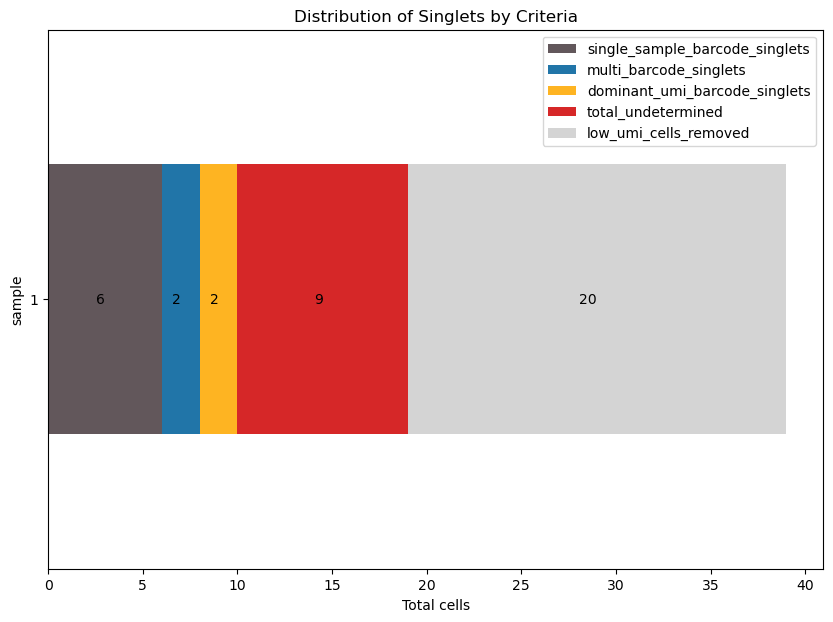

In [6]:
import matplotlib.pyplot as plt
#Plotting the distribution of low UMI cells, different kinds of singlets, and undetermined cells.
colors = ['#62575b', '#2175a8', '#feb422', '#d62728', '#d4d4d4']  # Example colors, modify as needed
plotData = stats.set_index('sample', inplace=False).drop(columns = ['dataset', 'total_cells', "total_singlets"])

# Plotting
ax = plotData.plot(kind='barh', stacked=True, figsize=(10, 7), color=colors)

for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', (p.get_x() + p.get_width()/2, p.get_y() + p.get_height()/2), ha='right', va='center')

ax.set_xlabel('Total cells')
ax.set_title('Distribution of Singlets by Criteria')
plt.show()


The above plot shows that the data we had contained different kind of
singlets: 6 single-barcode cells, 2 cells which had more than one
barcode but with same combination being present in more than one cell, 2
cells that had one dominant barcode. The data also contained 9 cells
which singletCode could not determine as being truly singlets and 20
cells whose barcode UMI counts were below the set threshold.

## Understanding the output files

To understand some of the files in the output, we can look at cell IDs
and their data in the original input sheet

For the dominant\_umi\_singlets, there are two cell IDs. One of them is
TGTAAGCGTCTCGCGA. If we look at that entry in the input sheet and count
the number of UMI associated with each barcode, we see that one barcode
has 99 UMI counts while the second highest UMI count is 7. So, the cell
most likely has only one barcode associated with it and hence, a
singlet.

In [7]:
import pandas as pd
df[df['cellID'] == 'TGTAAGCGTCTCGCGA'].groupby(['cellID', 'barcode', 'sample']).size().reset_index(name='count').sort_values('count', ascending=False).reset_index(drop=True)

,cellID,barcode,sample,count
0,TGTAAGCGTCTCGCGA,ATTGTTGTTGCAGATGCAGTTGATGCTGATGAAGTTGTACAAGGTC...,1,99
1,TGTAAGCGTCTCGCGA,ATTCGACTTGATCTTCTAGAACATGGTGAACTAGCAGGTGCTGATC...,1,7
2,TGTAAGCGTCTCGCGA,ATACTAGCTCAAGCAGTACTACTACTTCGTCTTCATGCAGAACAAC...,1,6
3,TGTAAGCGTCTCGCGA,ATAGATGCACTTGGTGGTCGAGTTCTAGTTGTAGCTGATCGTCCAG...,1,6
4,TGTAAGCGTCTCGCGA,ATTCGACCAGAACCACATGCAGTTCAACGTGTTCGAGGTGTAGATG...,1,6
...,...,...,...,...
82,TGTAAGCGTCTCGCGA,ATAGTAGTAGCTGTTGGTGTTGAAGTACTTCCTCTTGCTCCTCGTG...,1,1
83,TGTAAGCGTCTCGCGA,ATAGTAGATGAACGTCCTCTACATGTTCTTCGTCAAGTACCAGCAC...,1,1
84,TGTAAGCGTCTCGCGA,ATAGTACATGGTGGACCTGGACTTCGAGATGGAGCTCTTGTTCCTG...,1,1
85,TGTAAGCGTCTCGCGA,ATAGGAGTAGTTGGTGATGGTCTACCAGAAGGTGAAGGTGGAGAAG...,1,1


Next, we can look at multi-barcode singlets. There are two cell IDs:
AGGCTGCTCTTTCCGG and GAGGGATGTAACATCC. If we look at the barcodes with
greater than 2 UMI counts, we see that they have the same combination.
The only way this can occur is if a cell receives multiple barcode
initially and then divides.

In [8]:
(df[df['cellID'] == 'AGGCTGCTCTTTCCGG']
 .groupby(['cellID', 'barcode', 'sample'])
 .size()
 .reset_index(name='count')
 .sort_values('count', ascending=False)
 .query('count >= 2')
 .reset_index(drop=True)
)

,cellID,barcode,sample,count
0,AGGCTGCTCTTTCCGG,ATAGGAGTAGTTGGTGATGGTCTACCAGAAGGTGAAGGTGGAGAAG...,1,13
1,AGGCTGCTCTTTCCGG,ATTGAACGTGGAGTTGAACTTGTACTACGAGTACGTCTAGAACATG...,1,2


## scRNAseq data

Further single-cell RNAseq analysis with both scRNAseq data and singlet
information from singletCode output

Install and import scanpy for further single-cell RNAseq analysis

In [ ]:
!pip scanpy[leiden]

In [9]:
#Import scanpy
import scanpy as sc

Reading the scRNAseq input data in h5ad format

In [10]:
#Reading the scRNAseq data in h5ad format
adata = sc.read_h5ad(f"{path}/inputFiles/JiangEtAlSubset_scRNAseqData.h5ad")
adata

AnnData object with n_obs × n_vars = 39 × 36601
    var: 'gene_ids', 'feature_types'

Making copies of singletCode input/output to use them along with
scRNAseq data. The -1 is added to cell IDs to match the cell IDs seen in
10x format data.  
**NOTE**: It may not be needed for your actual data.

In [11]:
singleCellDf = df.copy()
singleCellDf['cellID'] = singleCellDf['cellID'] + "-1"
singleCellDf = singleCellDf.drop_duplicates(subset = 'cellID')
cellLabelListSingleCell = cellLabelList.copy()
cellLabelListSingleCell['cellID'] = cellLabelListSingleCell['cellID'] + "-1"
cellLabelListSingleCell = cellLabelListSingleCell.drop_duplicates(subset='cellID').reset_index(drop = True)

### Calculating total counts and genes identified per cell.

**NOTE**: In this vignette we are not doing any actual QC - but in
actual analysis, it would need to be done.

In [12]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

### Calculating PCA and plotting variance ratio vs ranking

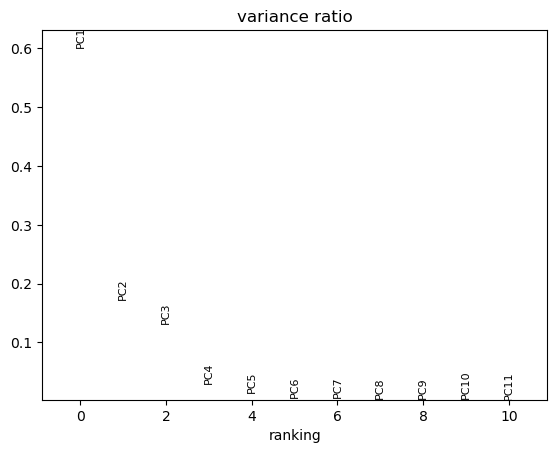

In [13]:
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata, n_pcs=10)

Identifying cells that were thresholded by singletCode as low UMI by
identifying cells that were in the original list provided to singletCode
but not labeled as either singlet or undetermined. Then creating a list
of annotations of singletStatus(singlet, multiplet, low UMI) for all
cells

In [14]:
umiCutoff = pd.DataFrame(
    singleCellDf.loc[~singleCellDf['cellID'].isin(cellLabelListSingleCell['cellID']), 'cellID']
    .drop_duplicates()
    .reset_index(drop=True), 
    columns=['cellID']
)
umiCutoff['label'] = "Low UMI"

In [15]:
cellIDLabels = cellLabelListSingleCell.drop(columns = ['barcode', 'sample', 'nUMI']).drop_duplicates().reset_index(drop = True)

In [16]:
#Creating a list of cell IDs with annotation of whether singlet, multiplet or low UMI.
labelID = pd.concat([umiCutoff, cellIDLabels]).reset_index(drop=True)
labelID = labelID.set_index(labelID['cellID']).drop(columns = ['cellID'])
#Adding the labels to cells in the adata to visualise it
adata.obs["singletStatus"] = labelID

### Visualising the cells in PCA space

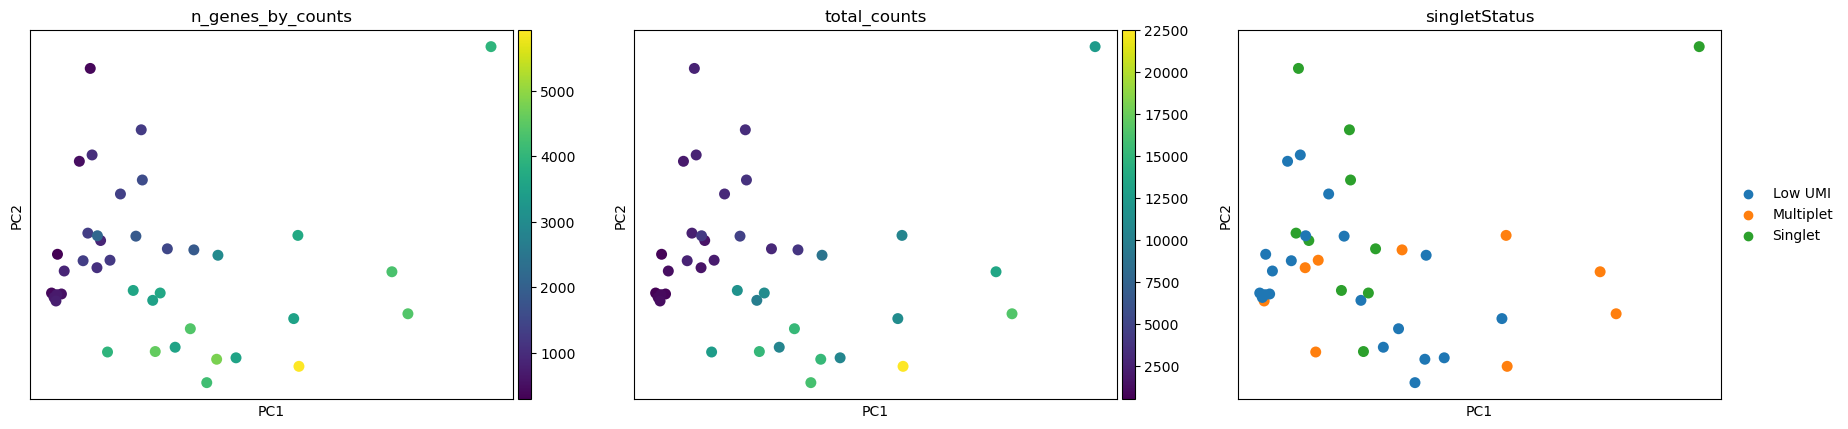

In [17]:
sc.pl.pca(
    adata,
    color = ['n_genes_by_counts', 'total_counts', 'singletStatus'],
    size = 250
)

### Calculating neigbours and UMAP for further visualisation

In [ ]:
sc.pp.neighbors(adata)
sc.tl.umap(adata, random_state=101010)

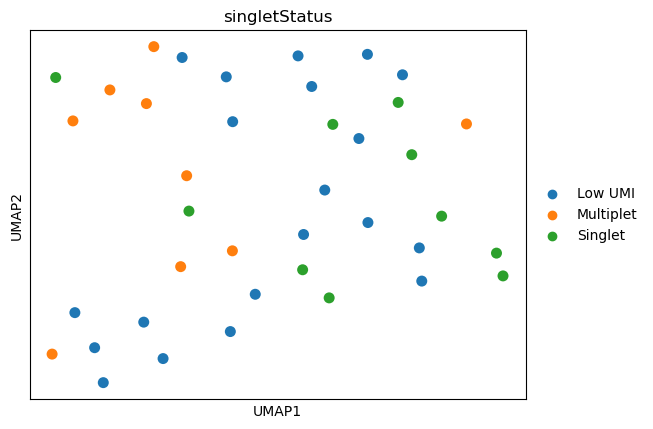

In [19]:
sc.pl.umap(
    adata,
    color=['singletStatus'],
    # Setting a smaller point size to get prevent overlap
    size=250,
)

### Saving the AnnData

In [20]:
adata.write(f"{outputPath}/JiangEtAlSubset.h5ad")